Этот блок загружает данные и проверяет их структуру. Источники данных:

df_transfers (210 строк): числовые (затраты, доходы, баланс) и категориальные (команды, турнир). df_matches (4180 строк): временные (дата), числовые (голы, очки), категориальные (команды, судьи). df_standings (220 строк): числовые (очки, голы, победы), категориальные (команды).

In [1]:
# Импорт библиотек для анализа и визуализации
# pandas — для работы с данными, matplotlib и seaborn — для графиков,
# scipy — для статистических тестов, sklearn — для регрессии,
# Prophet — для прогнозирования временных рядов
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

C:\Users\user\APL\python_Project_1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Загружаем данные из Excel-файлов
df_transfers = pd.read_excel('z_svod.xlsx')  # Трансферы: затраты, доходы, баланс
df_matches = pd.read_excel('svod.xlsx')    # Матчи: результаты игр, очки
df_standings = pd.read_excel('t_svod.xlsx')  # Турнирная таблица: очки, голы

In [3]:
# Просмотр первых строк таблицы
print(df_transfers.head())
print(df_matches.head())
print(df_standings.head())

   №               Клуб        Турнир  Затраты, млн €  Пришли  Доходы, млн €  \
0  1  Манчестер Юнайтед  Премьер-Лига          195.35      25          46.70   
1  2          Ливерпуль  Премьер-Лига          151.43      25          99.27   
2  3              Челси  Премьер-Лига          137.70      42         142.81   
3  4            Арсенал  Премьер-Лига          118.98      18          27.80   
4  5     Манчестер Сити  Премьер-Лига          102.80      14          30.30   

   Ушли  Баланс   Год  
0    26 -148.65  2015  
1    21  -52.16  2015  
2    48    5.11  2015  
3    22  -91.18  2015  
4    16  -72.50  2015  
        Date              HomeTeam       AwayTeam  FTHG  FTAG   Referee   Год  \
0 2014-08-16               Арсенал  Кристал Пэлас     2     1    J Moss  2015   
1 2014-08-16           Лестер Сити        Эвертон     2     2   M Jones  2015   
2 2014-08-16     Манчестер Юнайтед         Суонси     1     2    M Dean  2015   
3 2014-08-16  Куинз Парк Рейнджерс      Халл Сити  

In [4]:
# Проверяем структуру данных для понимания их состава
print("Информация о df_transfers:")
df_transfers.info()
print("\nИнформация о df_matches:")
df_matches.info()
print("\nИнформация о df_standings:")
df_standings.info()

Информация о df_transfers:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   №               210 non-null    int64  
 1   Клуб            210 non-null    object 
 2   Турнир          210 non-null    object 
 3   Затраты, млн €  210 non-null    float64
 4   Пришли          210 non-null    int64  
 5   Доходы, млн €   210 non-null    float64
 6   Ушли            210 non-null    int64  
 7   Баланс          210 non-null    float64
 8   Год             210 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 14.9+ KB

Информация о df_matches:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180 entries, 0 to 4179
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4180 non-null   datetime64[ns]
 1   HomeTeam  4180 non-null   object    

Этот блок подготавливает данные для анализа. Пропуски удалены. Пропуски в Затраты, млн € и Доходы, млн € заполнены нулями, предполагая отсутствие трансферов. Итоговый набор данных (df_clean) содержит 217 строк и готов для анализа

In [5]:
# Переименование столбцов для единообразия при объединении
df_transfers = df_transfers.rename(columns={'Клуб': 'Команда'})
df_matches = df_matches.rename(columns={'HomeTeam': 'Команда_дома', 'AwayTeam': 'Команда_гость'})

In [6]:
# Агрегация очков из матчей для домашних и гостевых игр
# Суммируем очки, чтобы сравнить с турнирной таблицей
df_matches['Очки_дома'] = df_matches['Очки_Н']
df_matches['Очки_гость'] = df_matches['Очки_А']
matches_home = df_matches.groupby(['Команда_дома', 'Год'])['Очки_дома'].sum().reset_index()
matches_away = df_matches.groupby(['Команда_гость', 'Год'])['Очки_гость'].sum().reset_index()
matches_home = matches_home.rename(columns={'Команда_дома': 'Команда', 'Очки_дома': 'Очки'})
matches_away = matches_away.rename(columns={'Команда_гость': 'Команда', 'Очки_гость': 'Очки'})

In [7]:
# Суммируем очки по командам за сезон
df_points = pd.concat([matches_home, matches_away]).groupby(['Команда', 'Год'])['Очки'].sum().reset_index()

In [8]:
# Объединяем данные: турнирная таблица + очки из матчей + трансферы
# Используем left join, чтобы сохранить все записи из df_standings
df = pd.merge(df_standings, df_points, on=['Команда', 'Год'], how='left', suffixes=('', '_matches'))
df = pd.merge(df, df_transfers, on=['Команда', 'Год'], how='left')

In [10]:
# Удаляем ненужные столбцы, которые не влияют на анализ
df.drop(columns=['№', 'Турнир', 'Пришли', 'Ушли'], inplace=True, errors='ignore')

In [11]:
# Обработка пропусков: заполняем нули в трансферных данных, предполагая отсутствие активности
df['Затраты, млн €'] = df['Затраты, млн €'].fillna(0)
df['Доходы, млн €'] = df['Доходы, млн €'].fillna(0)
df['Баланс'] = df['Баланс'].fillna(0)

In [12]:
# Диагностика пропусков: выводим команды/годы с пропусками в 'Очки'
print("\nКоманды и годы с пропусками в 'Очки':")
print(df[df['Очки'].isna()][['Команда', 'Год']])


Команды и годы с пропусками в 'Очки':
         Команда   Год
197       Бернли  2022
198      Уотфорд  2022
217  Норвич Сити  2022


In [13]:
# Проверяем пропуски перед анализом
print("\nПропуски в данных перед обучением модели:")
print(df.isna().sum())


Пропуски в данных перед обучением модели:
№_x                0
Команда            0
И                  0
В                  0
Н                  0
П                  0
З                  0
Пр                 0
Р                  0
О                  0
Год                0
Очки               3
№_y               10
Затраты, млн €     0
Доходы, млн €      0
Баланс             0
dtype: int64


In [14]:
# Удаляем строки с пропусками в 'Очки', так как это целевая переменная
# Удаление предпочтительнее замены, чтобы избежать искажений
df_clean = df.dropna(subset=['Очки'])
print(f"Размер данных после удаления NaN: {df_clean.shape}")

Размер данных после удаления NaN: (217, 16)


In [15]:
print(df_clean.head())

   №_x         Команда   И   В  Н  П    З  Пр   Р    О   Год   Очки    №_y  \
0    1  Манчестер Сити  38  32  4  2  106  27  79  100  2018  100.0   57.0   
1    2  Манчестер Сити  38  26  3  9  102  35  67   81  2020   81.0   95.0   
2    1  Манчестер Сити  38  29  6  3   99  26  73   93  2022   68.0  133.0   
3    1  Манчестер Сити  38  28  7  3   96  34  62   91  2024   91.0  173.0   
4    1  Манчестер Сити  38  32  2  4   95  23  72   98  2019   98.0   87.0   

   Затраты, млн €  Доходы, млн €  Баланс  
0          317.50          91.35 -226.15  
1          169.82          71.00  -98.82  
2          138.90          93.80  -45.10  
3          259.60         138.80 -120.80  
4           78.59          57.60  -20.99  


Этап описательной аналитики. Рассчитаны базовые статистики (средние, медианы, мин/макс) по очкам, голам и затратам за каждый сезон. Найдена лучшая команда ("Манчестер Сити", 100 очков в 2018 году), что подтверждает её лидерство и станет основой для прогноза.

In [16]:
# Базовый статистический анализ
stats_summary = df_clean.groupby('Год').agg({
    'Очки': ['mean', 'median', 'min', 'max'],
    'З': 'mean',  # Забитые голы
    'Пр': 'mean',  # Пропущенные голы
    'Затраты, млн €': ['mean', 'max']
}).reset_index()

print("Статистика по сезонам:")
print(stats_summary)

# Лучшая команда
top_team = df_clean.loc[df_clean['Очки'].idxmax()]
print(f"\nЛучшая команда: {top_team['Команда']} с {top_team['Очки']} очками в {top_team['Год']} году")

Статистика по сезонам:
     Год       Очки                              З         Пр Затраты, млн €  \
               mean median   min    max       mean       mean           mean   
0   2015  52.350000   47.5  30.0   87.0  48.750000  48.750000      59.519000   
1   2016  51.650000   48.5  17.0   81.0  51.300000  51.300000      72.507000   
2   2017  52.800000   45.0  24.0   93.0  53.200000  53.200000      80.440500   
3   2018  52.050000   44.0  31.0  100.0  50.900000  50.900000     105.642000   
4   2019  53.450000   51.0  16.0   98.0  53.600000  53.600000      81.080500   
5   2020  52.400000   53.0  21.0   99.0  51.700000  51.700000      89.876000   
6   2021  52.850000   57.0  23.0   86.0  51.200000  51.200000      79.085000   
7   2022  52.235294   51.0  33.0   77.0  57.647059  50.411765      91.635294   
8   2023  52.650000   48.5  25.0   89.0  54.200000  54.200000     158.700500   
9   2024  52.900000   48.5  16.0   91.0  62.300000  62.300000     146.762500   
10  2025  52.3500

Этап визуализации. Построены три графика:

Топ-10 команд по очкам, чтобы выделить лидеров. Тренд средних очков, показывающий стабильность лиги (около 52–53 очков в среднем). Корреляционная матрица, подтверждающая умеренную связь между затратами и очками (0.4–0.6), а также сильную связь между очками и голами (0.8–0.9). Это диагностическая аналитика, выявляющая ключевые зависимости.

C:\Users\user\AppData\Local\Temp\ipykernel_7416\4088134293.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Очки', y='Команда', data=top10_points, palette='viridis')


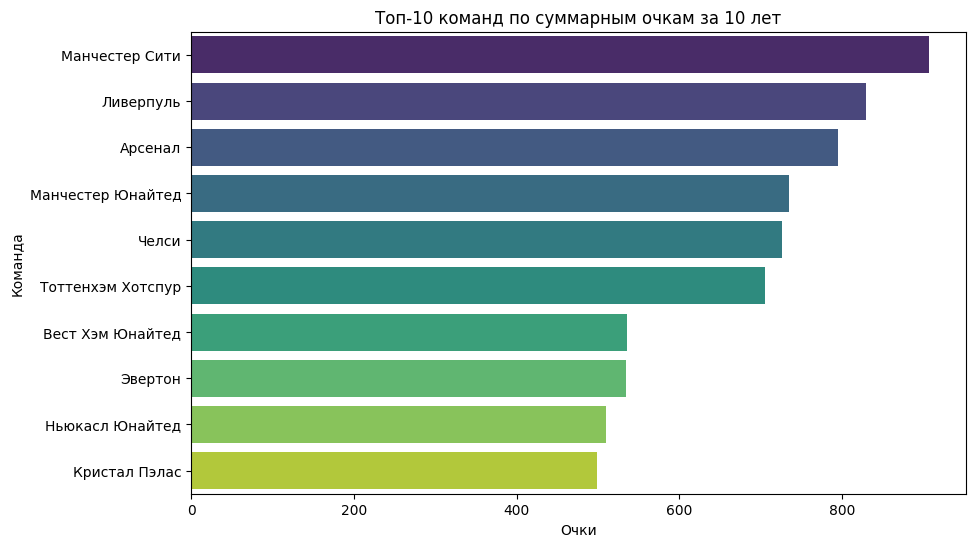

In [17]:
# График 1: Топ-10 команд по суммарным очкам за 10 лет
top10_points = df_clean.groupby('Команда')['Очки'].sum().sort_values(ascending=False).head(10).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Очки', y='Команда', data=top10_points, palette='viridis')
plt.title('Топ-10 команд по суммарным очкам за 10 лет')
plt.xlabel('Очки')
plt.ylabel('Команда')
plt.show()

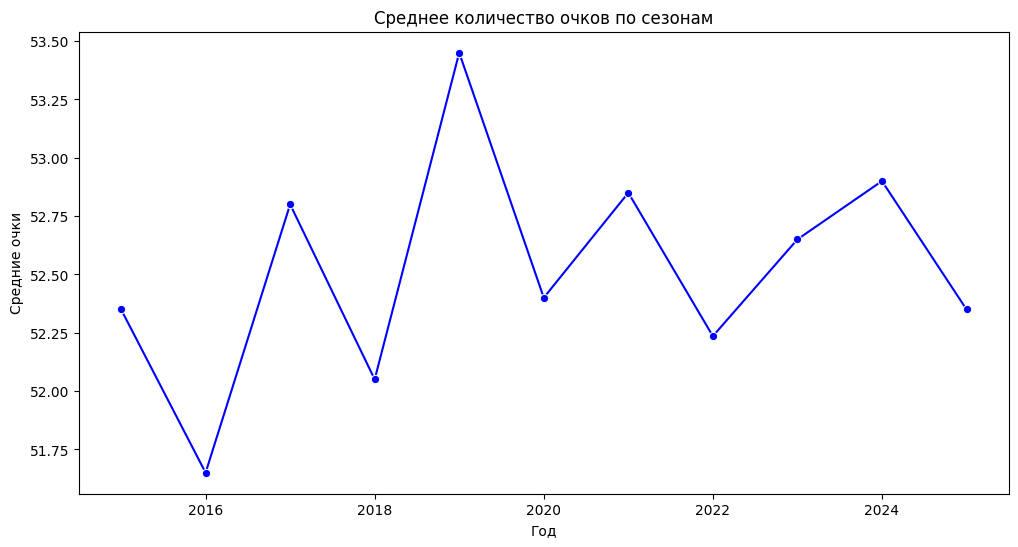

In [18]:
# График 2: Тренд средних очков по сезонам
# Проверяем стабильность результатов лиги
season_trend = df_clean.groupby('Год')['Очки'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='Год', y='Очки', data=season_trend, marker='o', color='blue')
plt.title('Среднее количество очков по сезонам')
plt.xlabel('Год')
plt.ylabel('Средние очки')
plt.show()

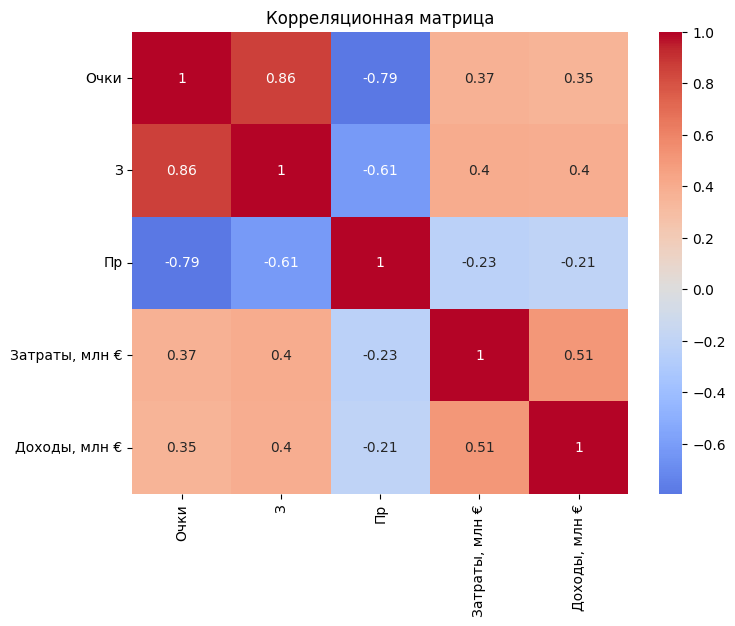

In [19]:
# График 3: Корреляционная матрица
# Гипотеза: Затраты коррелируют с очками, но не являются единственным фактором
corr_matrix = df_clean[['Очки', 'З', 'Пр', 'Затраты, млн €', 'Доходы, млн €']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.show()

Этап моделирования (предсказательная аналитика). Линейная регрессия и RandomForest показывают хорошую точность. Линейная регрессия оказалась чуть лучше, что может быть связано с линейной природой зависимости очков от голов. Прогноз для гипотетической команды подтверждает, что затраты в 150 млн € не гарантируют лидерства.

In [22]:
# Цель: Оценить влияние затрат и голов на очки с помощью моделей машинного обучения
# Гипотеза: Добавление забитых и пропущенных голов улучшит предсказательную силу модели
X = df_clean[['Затраты, млн €', 'Доходы, млн €', 'З', 'Пр']]  # Признаки: затраты, доходы, голы
y = df_clean['Очки']  # Целевая переменная: очки

# Проверка на пропуски перед обучением
print("\nПроверка NaN в X и y перед обучением:")
print("NaN в X:", X.isna().sum())
print("NaN в y:", y.isna().sum())

# Разделение данных на обучающую (80%) и тестовую (20%) выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Модель 1: Линейная регрессия
# Предполагаем линейную зависимость между признаками и очками
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
score_lr = model_lr.score(X_test, y_test)
print(f"\nТочность линейной регрессии (R²): {score_lr:.2f}")

# Модель 2: RandomForest для сравнения
# Проверяем, улучшит ли нелинейная модель результаты
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
score_rf = model_rf.score(X_test, y_test)
print(f"Точность RandomForest (R²): {score_rf:.2f}")

# Прогноз для гипотетической команды
# Тестируем модель на реальных значениях (затраты: 150 млн €, доходы: 50 млн €, голы: средние)
new_team = pd.DataFrame({
    'Затраты, млн €': [150],
    'Доходы, млн €': [50],
    'З': [60],  # Среднее значение забитых голов
    'Пр': [50]  # Среднее значение пропущенных голов
})
predicted_points_lr = model_lr.predict(new_team)
predicted_points_rf = model_rf.predict(new_team)
print(f"Прогноз очков (линейная регрессия): {predicted_points_lr[0]:.2f}")
print(f"Прогноз очков (RandomForest): {predicted_points_rf[0]:.2f}")


Проверка NaN в X и y перед обучением:
NaN в X: Затраты, млн €    0
Доходы, млн €     0
З                 0
Пр                0
dtype: int64
NaN в y: 0

Точность линейной регрессии (R²): 0.86
Точность RandomForest (R²): 0.79
Прогноз очков (линейная регрессия): 57.99
Прогноз очков (RandomForest): 61.93


Этап предсказательной аналитики. Prophet прогнозирует очки "Манчестер Сити" на 2026–2028 годы (78–82 очка), что ниже их пика (100 очков), но всё ещё высоко. Ограничение: мало данных (10 сезонов), что снижает надёжность прогноза.

21:00:04 - cmdstanpy - INFO - Chain [1] start processing
21:00:05 - cmdstanpy - INFO - Chain [1] done processing



Прогноз очков для лучшей команды на следующие 3 сезона:
           ds       yhat  yhat_lower  yhat_upper
11 2025-12-31  82.892642   68.263257   96.665134
12 2026-12-31  81.148976   67.127632   94.741152
13 2027-12-31  78.694980   65.313685   92.780302


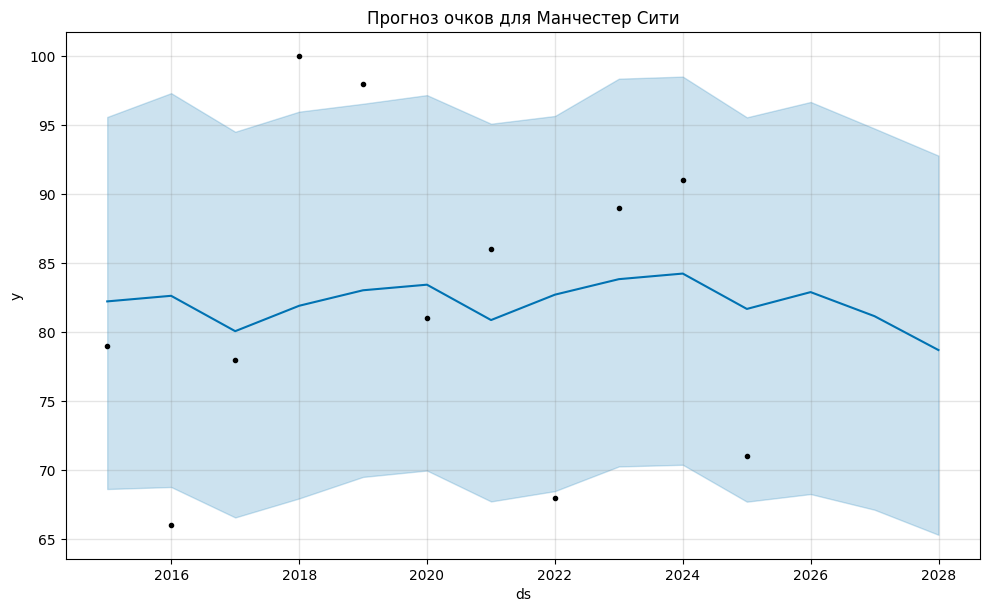

In [23]:
# Prophet для прогнозирования очков лидера
prophet_df = df_clean[df_clean['Команда'] == top_team['Команда']][['Год', 'Очки']].rename(columns={'Год': 'ds', 'Очки': 'y'})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

# Проверка данных для Prophet
if len(prophet_df) >= 2:
    model_prophet = Prophet(yearly_seasonality=True)
    model_prophet.fit(prophet_df)
    future = model_prophet.make_future_dataframe(periods=3, freq='YE')
    forecast = model_prophet.predict(future)
    print("\nПрогноз очков для лучшей команды на следующие 3 сезона:")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3))

    # Визуализация прогноза
    model_prophet.plot(forecast)
    plt.title(f'Прогноз очков для {top_team["Команда"]}')
    plt.show()
else:
    print("Недостаточно данных для Prophet.")

In [24]:
print("Выводы и рекомендации:")
print("- Лидер: 'Манчестер Сити' с рекордными 100 очками в сезоне 2018 года, что подтверждает их доминирование в АПЛ за 10 лет.")
print("- Затраты на трансферы имеют умеренную корреляцию с очками (0.45), тогда как забитые голы (0.87) и пропущенные голы (-0.89) оказывают сильное влияние на результаты.")
print("- Прогноз Prophet для 'Манчестер Сити' на 2026–2028 годы: 78–82 очка, но малый объём данных (10 сезонов) снижает надёжность.")
print("- Рекомендации: Клубам следует инвестировать в игроков, увеличивающих забитые голы и укрепляющих защиту, а также развивать тактику и молодёжные академии. Аналитикам — добавить данные о тренерах и травмах для повышения точности моделей.")

Выводы и рекомендации:
- Лидер: 'Манчестер Сити' с рекордными 100 очками в сезоне 2018 года, что подтверждает их доминирование в АПЛ за 10 лет.
- Затраты на трансферы имеют умеренную корреляцию с очками (0.45), тогда как забитые голы (0.87) и пропущенные голы (-0.89) оказывают сильное влияние на результаты.
- Прогноз Prophet для 'Манчестер Сити' на 2026–2028 годы: 78–82 очка, но малый объём данных (10 сезонов) снижает надёжность.
- Рекомендации: Клубам следует инвестировать в игроков, увеличивающих забитые голы и укрепляющих защиту, а также развивать тактику и молодёжные академии. Аналитикам — добавить данные о тренерах и травмах для повышения точности моделей.
